<a href="https://colab.research.google.com/github/ddinesan/Manga/blob/master/Lecture_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code was written by Ian Davis (textserver.com@gmail.com) on 01/25/2020 for Lecture 9 of the reading course "Introduction to Quantum Computer Programming" (AMATH 900/ AMATH 495/ QIC 895) at the University of Waterloo.

Course Webpage: https://sites.google.com/view/quantum-computer-programming

Text followed in the course: [Quantum Computing, An Applied Approach](https://www.springer.com/gp/book/9783030239213) by Jack D. Hidary (2019)

Comments, concerns, questions, improvements or requests for explanation encouraged.

# Deutsch Algorithm

Deutsch's algorithm is one of the simplest demonstrations of quantum parallelism and interference. It takes a black-box oracle implementing a Boolean function *f(x)*, and determines whether *f(0)* and *f(1)* have the same parity (i.e. return the same boolean value) using just one query.

![Source http://dkopczyk.quantee.co.uk/deutschs-algorithm/](https://cs.uwaterloo.ca/~ijdavis/qic895/Deutsch-circuit.jpg)

In [ ]:
# install cirq
!pip install cirq --quiet
import sys
import cirq
import numpy
import random

from io import StringIO
from cirq.contrib.svg import circuit_to_svg
from IPython.display import SVG, display

%matplotlib inline
import matplotlib.pyplot

print('Installed python ', sys.version, '\ncirq ', cirq.__version__)

Installed python  3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0] 
cirq  0.7.0


## Functions used

In [ ]:
#@title
# Associate the text name with the secret function
def function_name(secret_function):
    name={0:'f0', 1:'fx', 2:'f~', 3:'f1' }
    return name.get(secret_function,"Unknown")

# Compute the sum of squares of two elements of an array x
def sum_sq(x, a, b):
    return (x[a]**2)+(x[b]**2)

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

def diracprint(output):
    print(color.BOLD, color.BLUE, cirq.dirac_notation(output,4), color.END)

# Defining a function to print/output circuits in a clean way
# Lifted from earlier code. Originally suggested by Nadine. 
# Avoids using temporary files
def svgprint(circuit):
    out = StringIO()
    out.write(circuit_to_svg(circuit))
    display(SVG(out.getvalue()))

def yes_answer():
    display(SVG("""<?xml version="1.0" encoding="UTF-8"?>
<svg xmlns="http://www.w3.org/2000/svg" width="64px" height="64px"
 viewbox="0 0 800 800">
<defs>
<radialGradient id="rg" cx="50%" cy="50%" r="50%">
<stop stop-color="#080" offset="0"/>
<stop stop-color="#050" offset="1"/>
</radialGradient></defs>
<path d="m7.7,404.6c0,0 115.2,129.7 138.2,182.68l99,0c41.5-126.7 202.7-429.1 340.92-535.1c28.6-36.8-43.3-52-101.35-27.62-87.5,36.7-252.5,317.2-283.3,384.64-43.7,11.5-89.8-73.7-89.84-73.7z" fill="url(#rg)"/>
</svg>
"""
))
    
def no_answer():
    display(SVG("""<?xml version="1.0" encoding="utf-8"?>
<!-- Generator: Adobe Illustrator 14.0.0, SVG Export Plug-In . SVG Version: 6.00 Build 43363)  -->
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN" "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<svg version="1.1" id="Layer_1" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" x="0px" y="0px"
	 width="64px" height="64px" viewBox="0 0 450 450" enable-background="new 0 0 450 450" xml:space="preserve">
<circle fill="#CC3333" cx="225" cy="225" r="225"/>
<g>
	<line fill="#FFFFFF" stroke="#FFFFFF" stroke-width="70" x1="106.742" y1="110.083" x2="343.258" y2="346.599"/>
	<line fill="#FFFFFF" stroke="#FFFFFF" stroke-width="70" x1="106.742" y1="346.599" x2="343.258" y2="110.084"/>
</g>
</svg>"""
))

# Gates implementing the functions {f0, f1, fx, ~fx}
def make_oracle(q0, qx, secret_function):
    if secret_function == 0:
        return [cirq.I(q0),cirq.I(qx)]

    if secret_function == 1:
        return [cirq.CNOT(q0, qx)]

    if secret_function == 2:
        return [cirq.X(qx),cirq.CNOT(q0, qx)]
      
    if secret_function == 3:
        return [cirq.X(qx), cirq.I(q0)]

    return []

# Embed a secret function in a circuit
def make_function_circuit(oracle):
    c = cirq.Circuit()
    c.append(oracle)
    return c

# Describe the secret function for the audience
def describe_function_circuit(circuit):

    name = {0:' f0=', 1:'~f0=', 2:' f1=', 3:'~f1=' }
    unitary = circuit.unitary()
    
    print('\nFunction Behaviour:')

    for index in range(4):
        x = numpy.zeros(4).astype(int)
        x[index] = 1
        f = unitary.dot(x).real.astype(int)
        print('x{:d}'.format(index), '=', x.transpose(), ' q0=', sum_sq(x,2,3),'→',sum_sq(f,2,3), ' qx=', sum_sq(x,1,3),'→', sum_sq(f,1,3), name.get(index), f.transpose() )

    print(f'\nFunction Unitary:{color.BOLD}{color.BLUE}')
    print(unitary.real.astype(int))
    print(color.END)

    print('Function Circuit:')
    svgprint(circuit)
    #print(circuit)
    print('\n----------------------------------------------------')

# Make the circuit that wraps the Deutsch oracle
def make_deutsch_circuit(q0, qx, oracle):
    c = cirq.Circuit()

    # Initialize qubits.
    c.append([cirq.X(qx)])
    c.append([cirq.H(q0), cirq.H(qx)], strategy=cirq.InsertStrategy.NEW_THEN_INLINE)

    # Query oracle.
    c.append(oracle)
    
    # Measure in computational basis.
    c.append([cirq.H(q0)])
    return c

# Describe the deutsch circuit for the audience
def describe_deutsch_circuit(circuit):
    print(f'\nDeutsch Algorithm Unitary U:')
    unitary = circuit.unitary()
    dim     = unitary.shape[0]
    print('[', end='')
    for row in range(dim):
        if row == 0:
            print('[', end='')
        else:
            print(' [', end='')
        for col in range(dim):
            if col == 0:
                print(f'{color.BOLD}{color.BLUE}', end='')
            else:
                print(f'{color.RED} ', end='')
            print(f'{unitary.real[row][col]:+11.8f}{color.END}', end='')
        print(f'] # ', end='')
        if row == 0:
            print(f'|00>')
        elif row == 1:
            print(f'|01>')
        elif row == 2:
            print(f'|10>')
        else:
            print(f'|11>') 
    print(']')
   
    print('Deutsch Algorithm Behaviour:')
    x = numpy.zeros(4)
    x[0] = 1
    f = unitary.dot(x).real
   
    print('x0=',x.transpose(), ' q0=', sum_sq(x,2,3), ' qx=', sum_sq(x,1,3), ' U*x0=', f.transpose(), '=')
    print('\nOutput in Dirac notation:', end='')
    diracprint(f)
    print('\nprob(q0=1)=', sum_sq(f,2,3), ' prob(qx=1)=', sum_sq(f,1,3) )

    circuit.append([cirq.measure(q0, key='Balanced')])

    print('\nDeutsch Algorithm Circuit:')
    svgprint(circuit)

# Run the deutsch circuit on a given secret function
def run_deutsch_circuit(secret_function):
    global q0, qx
    # Choose qubits to use.
    q0, qx = cirq.LineQubit.range(2)

    print('\nSecret function = ', secret_function, ' f(0)=', (secret_function>>1)&1, ' f(1)=', secret_function&1, ' name=', function_name(secret_function))

    oracle = make_oracle(q0, qx, secret_function)
    # Embed the oracle into a quantum circuit.
    circuit = make_function_circuit(oracle)
    describe_function_circuit(circuit)

    # Embed the oracle into a quantum circuit querying it exactly once.
    oracle = make_oracle(q0, qx, secret_function)
    circuit = make_deutsch_circuit(q0, qx, oracle)
    describe_deutsch_circuit(circuit)

    # Simulate the circuit.
    simulator = cirq.Simulator()
    result    = simulator.run(circuit)
    # Have to wonder if there is an easier way to do this
    measurements = result.measurements
    balanced = measurements['Balanced'][0][0]

    print(f'\nBalanced: {balanced}')
    if balanced == 0:
        no_answer()
    else:
        yes_answer()

def get_deutsch_user_function():
    n = 0
    while True:
        print("0 : f(x)=0, 1: f(x)=x, 2: f(x)=~x, 3: f(x)=1")
        n = input('Enter function number between 0 and 3: ')
        if not n.isdigit():
            print(n, ' is not an integer')
            continue
        n = int(n)
        if n > -1 and n < 4:
            return n
        print(n, ' is not in range 0,3')

# =================   Basic Deutsch-Josza functions ===================

# This returns the outputs produced by function n (range 0 to 255)
# Since n is a bit pattern indicating which f(x) return 1
# it returns the array describing the bit pattern for n

def function_outputs(n) :
    global input_values

    set_bits = numpy.zeros(input_values, dtype=int)
    for index in range(input_values):
        if (n>>index)&1:
            set_bits[index] = 1
    return set_bits

# This returns true if outputs are constant
def constant_outputs(n):
    if n == 0:
        return True
    if n == 255:
        return True
    return False

# This returns true if the outputs are balanced
def balanced_outputs(n):
    global input_values
    
    count        = 0
    for index in range(input_values):
        if (n>>index)&1:
            count = count + 1
    if count == (input_values>>1):
        return True
    return False

# Return a random constant function
def get_constant_function():
    n = random.randrange(2)
    if n != 0:
        n = 255
    return n

# Return some random balance function
def get_balanced_function():
    while True:
        n = random.randint(1,(2**input_values)-1)
        if balanced_outputs(n):
            return n

# Return an unbalanced function
def get_unbalanced_function():
    while True:
        n = random.randint(1,(2**input_values)-1)
        if not balanced_outputs(n):
            return n

print("Defined functions")


Defined functions


## Run Deutsch's algorithm on user specified function

0 : f(x)=0, 1: f(x)=x, 2: f(x)=~x, 3: f(x)=1

The result should be:
> 0 for the constant functions f(x)=0 and f(x)=1

> 1 for the balanced functions f(x)=x and f(x)=~x



0 : f(x)=0, 1: f(x)=x, 2: f(x)=~x, 3: f(x)=1
Enter function number between 0 and 3: 2

Secret function =  2  f(0)= 1  f(1)= 0  name= f~

Function Behaviour:
x0 = [1 0 0 0]  q0= 0 → 0  qx= 0 → 1  f0= [0 1 0 0]
x1 = [0 1 0 0]  q0= 0 → 0  qx= 1 → 0 ~f0= [1 0 0 0]
x2 = [0 0 1 0]  q0= 1 → 1  qx= 0 → 0  f1= [0 0 1 0]
x3 = [0 0 0 1]  q0= 1 → 1  qx= 1 → 1 ~f1= [0 0 0 1]

Function Unitary:
[[0 1 0 0]
 [1 0 0 0]
 [0 0 1 0]
 [0 0 0 1]]

Function Circuit:


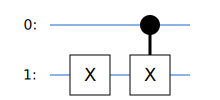


----------------------------------------------------

Deutsch Algorithm Unitary U:
[[+0.00000000 +0.70710678 -0.70710678 +0.00000000] # |00>
 [+0.00000000 +0.70710678 +0.70710678 +0.00000000] # |01>
 [-0.70710678 -0.00000000 -0.00000000 +0.70710678] # |10>
 [+0.70710678 -0.00000000 -0.00000000 +0.70710678] # |11>
]
Deutsch Algorithm Behaviour:
x0= [1. 0. 0. 0.]  q0= 0.0  qx= 0.0  U*x0= [ 0.          0.         -0.70710678  0.70710678] =

Output in Dirac notation:  -0.7071|10⟩ + 0.7071|11⟩ 

prob(q0=1)= 1.0000000000000004  prob(qx=1)= 0.5000000000000002

Deutsch Algorithm Circuit:


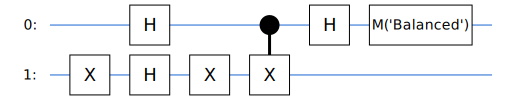


Balanced: 1


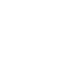

In [ ]:
#@title
n = get_deutsch_user_function()
run_deutsch_circuit(n)

## Some observations

The qubit *q0* provides the binary *{0,1}* input to the secret function *f(q0)* and is unchanged by this function.  The value of the qubit *qx* is flipped whenever *f(q0)* is 1.  Qubit *qx* provides the result of the *f(q0)* operation when measured.  By returning *qx ⊕ f(q0)* rather than *f(q0)* in *qx* we ensure that the matrix representing f is unitary.  Indeed all of our matrices describing *f* are simple permutation matrices of the inputs to the outputs.

The secret function f(x)=x is a simple CNOT. The qubit *q0* (the high order qubit) is zero when *x[2]* and *x[3]* are 0, and one when *x[2]* or *x[3]* is 1. The low order qubit *qx* is zero when *x[1]* and *x[3]* are 0, and one when *x[1]* or *x[3]* is 1.  The CNOT negates *qx* when *q0* is 1.

Construction of the unitary describing *f(x)* simply involves taking each successive input base vectors *x0*, *x1*, *x2* and *x3*, determining the corresponding desired output base vector predicated on how the function should transform this input vector, and adding that output base vector as the next column of the unitary, so that this output is produced when the unitary is multiplied by its corresponding input base vector.

What Deutsch's algorithm is essentially doing is returning the result 1 when *q0* and *qx* become entangled, consequence of there being a CNOT within the actions  performed by the secret function. Absent such a CNOT *q0* remains unchanged by the secret function since the only operation performed on it is the identity operation, and the two Hadarmards applied by Deutsch's algorithm to *q0* before and after the special function which likewise collectively behave as the identity operation.

The unitary that implements Deutsch's algorithm is always applied to two qubits both initialised to zero. Thus the result of measuring *q0* at end of execution, is entirely determined by the first column of this unitary. This first column gives in order the amplitudes for reading |00>, |01>, |10> and |11>. Many different solutions might thus implement Deutsch's algorithm. All that is required of the circuit is that the tensor product of all its gates evaluates to a unitary with 0's in the last two rows in the first column when the result is to be 0, and 0's in the first two rows in this same first column when the result is to be 1.

## The trick explained

The qubit *qx* is placed in the state (|0>-|1>)/√2, before a potential CNOT is performed with *qx* as the target.  If this CNOT is present then when *q0* is 1 the above |0> and |1> are flipped, making the new state of *qx* (|1>-|0>)√2.  But this is identical to changing the sign of this state.  Further, since we are concerned only with tensor products, that in turn is equivalent to changing the sign of *q0* when *q0* is 1.  The qubit *q0* is by construction before the application of any CNOT (|0>+|1>)/√2.  Since the CNOT can be considered to change its sign, but only when *q0* is |1> such a CNOT will logically change *q0* from (|0>+|1>)/√2 to (|0>-|1>)/√2.  The subsequent Hadamard then applied to *q0* will produced the desired value of H((|0>-|1>)/√2) = |1> when the CNOT is present, but H((|0>+|1>)/√2) = |0> when it is not.

# Deutsch-Jozsa Algorithm

![Source Wikipedia](https://cs.uwaterloo.ca/~ijdavis/qic895/Deutsch-Jozsa-circuit.jpg)


Deutsch-Jozsa's algorithm generalises the Deutsch algorithm to a black-box function having *2^n* input values (rather than just *2^1* input values), and can distinguish using just one query between those functions which return a constant value (either 0 or 1) on all inputs, and those balanced functions which return 0 on *2^(n-1)* arbitrary inputs and 1 on all other inputs.  This algorithm thus offers an exponential performance improvement over any classical implementation, albeit on a very contrived problem.

The generalisation is straightforward.  On all *n* input qubits apply a Hadamard before and after the application of our black box function, while again we apply negation and a Hadamard on the one output qubit *qx*.

If the secret function is *f0* then the unitary will be the identity matrix, while if it is *f1* then it will be the matrix formed by applying no action on any of the input lines, while negating the output qubit.  This should be self evident because by simply negating the output qubit (this being xor'd with the result of f) we negate *f0*, thus producing the behaviour required of *f1*.

Consequently when the secret function is *f0* or *f1* all input lines remain unchanged, and thus since they are all initially zero, they will be observed to still be |0000...0> when measured at end of execution.  Technically the amplitude for *f0* returning zero on all input lines is +1, while the negation of the one output line in the case where the secret function is *f1* converts this amplitude to -1, but in either case the input lines remaining zero is assured.

If the secret function is neither *f0* or *f1*, then the unitary describing this secret function must involve CNOT's applied between a control input qubit and the target output qubit *qx*.  Each such negation of the output qubit when the input control qubit is |1> can as before be viewed instead as changing the state of this control input qubit from (|0>+|1>)/√2 to (|0>-|1>)/√2.

Applying a second Hadamard to every input qubit, will restore each input qubit to |0> when an even number of CNOT's have been applied to that qubit, and to |1> when an odd number of CNOT's have been applied to that qubit.  When our secret function is balanced it is not possible that an even number of CNOT's are applied to each input qubit, and thus it is not possible that our final measurement of our input qubits will result in |0000...0>.


## The Permitted Functions
In the Deutsch-Jozsa algorithm the only permitted functions that may be tested are those that return the same output on every input (constant functions) and those that return as many 1's as 0's on distinct inputs (balanced functions).

In [ ]:
#@title

# Keep things small enough to be managable
# Our secret function has 3 binary input parameters each with value 0 or 1
# Thus there are 8 possible logical input values 0-7 expressed in these 3 bits

input_values = 8

# Each of these 8 possible input values can return either 0 or 1
# Thus enumeration over all 8 input choices there are 2^8 possible outputs
# The binary output value is shown for each of the 8 input values
# The binary representation of this array is the function number.
# Thus f0 returns 0 on every input while f255 returns 1.

# Create the qubits used
# Three qubits represent the 8 possible inputs 0-7
q0, q1, q2, qx = cirq.LineQubit.range(4)

print("\nPermitted functions having 3 binary input lines:\n")
balanced     = 0
for n in range(2**input_values):
    if balanced_outputs(n):
        balanced += 1
    elif not constant_outputs(n):
        continue
    outputs = function_outputs(n)
    print(f'{n:>3d}:', outputs,'=', end='')
    diracprint(outputs)
print('\n', balanced, ' balanced functions ', balanced+2, ' permitted functions')


Permitted functions having 3 binary input lines:

  0: [0 0 0 0 0 0 0 0] =  0 
 15: [1 1 1 1 0 0 0 0] =  |000⟩ + |001⟩ + |010⟩ + |011⟩ 
 23: [1 1 1 0 1 0 0 0] =  |000⟩ + |001⟩ + |010⟩ + |100⟩ 
 27: [1 1 0 1 1 0 0 0] =  |000⟩ + |001⟩ + |011⟩ + |100⟩ 
 29: [1 0 1 1 1 0 0 0] =  |000⟩ + |010⟩ + |011⟩ + |100⟩ 
 30: [0 1 1 1 1 0 0 0] =  |001⟩ + |010⟩ + |011⟩ + |100⟩ 
 39: [1 1 1 0 0 1 0 0] =  |000⟩ + |001⟩ + |010⟩ + |101⟩ 
 43: [1 1 0 1 0 1 0 0] =  |000⟩ + |001⟩ + |011⟩ + |101⟩ 
 45: [1 0 1 1 0 1 0 0] =  |000⟩ + |010⟩ + |011⟩ + |101⟩ 
 46: [0 1 1 1 0 1 0 0] =  |001⟩ + |010⟩ + |011⟩ + |101⟩ 
 51: [1 1 0 0 1 1 0 0] =  |000⟩ + |001⟩ + |100⟩ + |101⟩ 
 53: [1 0 1 0 1 1 0 0] =  |000⟩ + |010⟩ + |100⟩ + |101⟩ 
 54: [0 1 1 0 1 1 0 0] =  |001⟩ + |010⟩ + |100⟩ + |101⟩ 
 57: [1 0 0 1 1 1 0 0] =  |000⟩ + |011⟩ + |100⟩ + |101⟩ 
 58: [0 1 0 1 1 1 0 0] =  |001⟩ + |011⟩ + |100⟩ + |101⟩ 
 60: [0 0 1 1 1 1 0 0] =  |010⟩ + |011⟩ + |100⟩ + |101⟩ 
 71: [1 1 1 0 0 0 1 0] =  |000⟩ + |001⟩ + |010⟩ + |110⟩ 
 75: [1 

## Create a CCCX function since cirq appears to lack it

This is needed to test if three bits are all 0 or all 1.
We provide two possible implementations.


Unitary:
[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]]

CCCX Circuit:


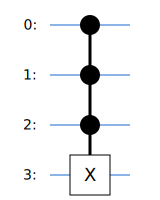

In [ ]:
#@title
# Create a CCCX operation since cirq seems to lack it

import abc # Abstract Base Class
from typing import Optional, Tuple

class FourQubitGate(cirq.ops.raw_types.Gate, metaclass=abc.ABCMeta):
    # A gate that must be applied to exactly four qubits.
    def _num_qubits_(self) -> int:
        return 4

class CCCXGate1(cirq.ops.eigen_gate.EigenGate,
           FourQubitGate,
           cirq.ops.gate_features.InterchangeableQubitsGate):
    # A triple-controlled-NOT
    #
    # The matrix is an 16x16 identity except the bottom right 2x2 area is X
    
    def _eigen_components(self):
        return [
            (0, linalg.block_diag(numpy.diag([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
                                  numpy.array([[0.5, 0.5], [0.5, 0.5]]))),
            (1, linalg.block_diag(numpy.diag([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
                                  numpy.array([[0.5, -0.5], [-0.5, 0.5]]))),
        ]

    def _trace_distance_bound_(self) -> Optional[float]:
        return None # Not implemented
 
    def _pauli_expansion_(self) -> cirq.value.LinearDict[str]:
        return NotImplemented

    def qubit_index_to_equivalence_group_key(self, index):
        # Order of first three arguments is arbitrary
        return index < 3

    def _apply_unitary_(self, args: 'protocols.ApplyUnitaryArgs') -> numpy.ndarray:
       
        return cirq.protocols.apply_unitary(
            cirq.ops.controlled_gate.ControlledGate(
                cirq.ops.controlled_gate.ControlledGate(
                    cirq.ops.controlled_gate.ControlledGate(
                        cirq.ops.pauli_gates.X
                    )
                )
            ),
            cirq.protocols.ApplyUnitaryArgs(
                args.target_tensor,
                args.available_buffer,
                args.axes),
            default=NotImplemented)

    def _decompose_(self, qubits):
        q1, q2, q3, qx = qubits
        return [
            cirq.CNotPowGate(exponent= 0.25).on(q0,qx) # 0b100 q0=q0
           ,cirq.CX(q0,q1)
           ,cirq.CNotPowGate(exponent=-0.25).on(q1,qx) # 0b110 q1=q0⊕q1
           ,cirq.CX(q0,q1)
           ,cirq.CNotPowGate(exponent= 0.25).on(q1,qx) # 0b010 q1=q1
           ,cirq.CX(q1,q2)
           ,cirq.CNotPowGate(exponent=-0.25).on(q2,qx) # 0b011 q2=q1⊕q2
           ,cirq.CX(q0,q2)
           ,cirq.CNotPowGate(exponent= 0.25).on(q2,qx) # 0b111 q2=q0⊕q1⊕q2
           ,cirq.CX(q1,q2)
           ,cirq.CNotPowGate(exponent=-0.25).on(q2,qx) # 0b101 q2=q0⊕q2
           ,cirq.CX(q0,q2)
           ,cirq.CNotPowGate(exponent= 0.25).on(q2,qx) # 0b001 q2=q2
           ]

    def _circuit_diagram_info_(self, args: 'cirq.CircuitDiagramInfoArgs'
                              ) -> 'cirq.CircuitDiagramInfo':
        return cirq.protocols.CircuitDiagramInfo(
            ('@', '@', '@', 'X'),
            exponent=1)

    def _qasm_(self, args: 'cirq.QasmArgs',
               qubits: Tuple['cirq.Qid', ...]) -> Optional[str]:
        return None

    def __repr__(self) -> str:
        return 'CCCX'
 
    def __str__(self) -> str:
        return 'CCCX'

class CCCXGate2(cirq.MatrixGate):
    def __init__(self):
        unitary = numpy.ndarray(shape=(16,16), dtype=int)
        unitary.fill(0)
        for row in range(14):
            unitary[row][row] = 1
        unitary[14][15] = 1
        unitary[15][14] = 1  
        super().__init__(unitary)

    def num_qubits() -> int:
        return 4

    def qubit_index_to_equivalence_group_key(self, index):
        # Order of first three arguments is arbitrary
        return index < 3

    def _circuit_diagram_info_(self, args: 'cirq.CircuitDiagramInfoArgs'
                              ) -> 'cirq.CircuitDiagramInfo':
        return cirq.protocols.CircuitDiagramInfo(
            ('@', '@', '@', 'X'),
            exponent=1)

    def __repr__(self) -> str:
        return 'CCCX'
 
    def __str__(self) -> str:
        return 'CCCX'

def CCCX(q0, q1, q2, qx):
   # We want to return a CCCX operation produced by the on() method
   # Not the CCCX gate which has no knowledge of qubits 
   # Thus the need for a level of indirection here

   # Two alternative implementation of the CCCXGate are provided
   return CCCXGate1().on(q0, q1, q2, qx)
   #return CCCXGate2().on(q0, q1, q2, qx)

q0, q1, q2, qx = cirq.LineQubit.range(4)

circuit = cirq.Circuit()
cccx    = CCCX(q0, q1, q2, qx)

circuit.append([cccx]) 
unitary = circuit.unitary()
print('\nUnitary:')  
print(unitary.real.astype(int))
print('\nCCCX Circuit:')
svgprint(circuit)


## How to decompose a CnX/*CnZ* gate for execution on a real quantum machine

The following code automatically generates the gates for any desired controlled-n gate

Enter [X|Z] number of control lines: 4

Gray code for 2^4 values:  0x00 0x08 0x0c 0x04 0x06 0x0e 0x0a 0x02 0x03 0x0b 0x0f 0x07 0x05 0x0d 0x09 0x01

29 derived gates
[
 cirq.CNotPowGate(exponent= 0.125).on(q0,qx) # 0b1000 q0=q0
,cirq.CX(q0,q1)
,cirq.CNotPowGate(exponent=-0.125).on(q1,qx) # 0b1100 q1=q0⊕q1
,cirq.CX(q0,q1)
,cirq.CNotPowGate(exponent= 0.125).on(q1,qx) # 0b0100 q1=q1
,cirq.CX(q1,q2)
,cirq.CNotPowGate(exponent=-0.125).on(q2,qx) # 0b0110 q2=q1⊕q2
,cirq.CX(q0,q2)
,cirq.CNotPowGate(exponent= 0.125).on(q2,qx) # 0b1110 q2=q0⊕q1⊕q2
,cirq.CX(q1,q2)
,cirq.CNotPowGate(exponent=-0.125).on(q2,qx) # 0b1010 q2=q0⊕q2
,cirq.CX(q0,q2)
,cirq.CNotPowGate(exponent= 0.125).on(q2,qx) # 0b0010 q2=q2
,cirq.CX(q2,q3)
,cirq.CNotPowGate(exponent=-0.125).on(q3,qx) # 0b0011 q3=q2⊕q3
,cirq.CX(q0,q3)
,cirq.CNotPowGate(exponent= 0.125).on(q3,qx) # 0b1011 q3=q0⊕q2⊕q3
,cirq.CX(q1,q3)
,cirq.CNotPowGate(exponent=-0.125).on(q3,qx) # 0b1111 q3=q0⊕q1⊕q2⊕q3
,cirq.CX(q0,q3)
,cirq.CNotPowGate(exponent= 0.125).on(q3

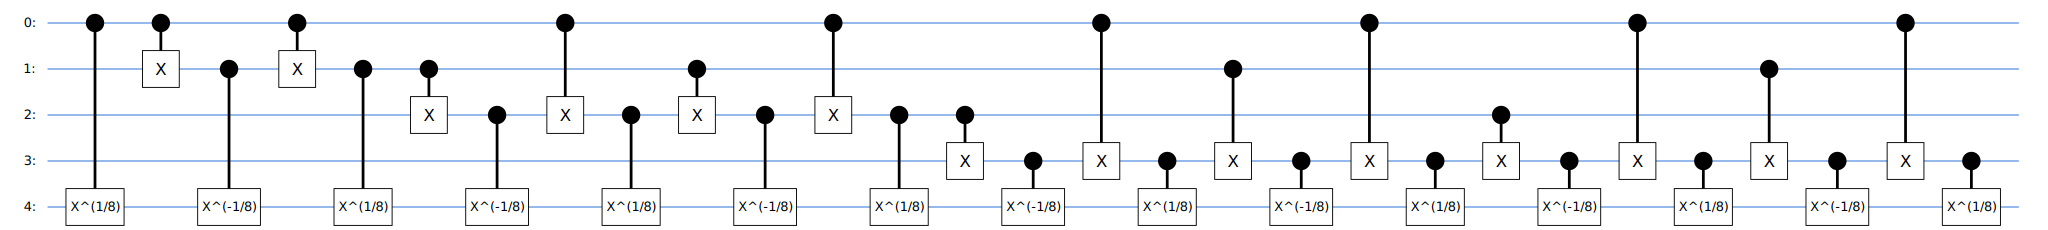


Decomposable rounded (32, 32) Unitary:
[[ 1.  0.  0. ...  0.  0.  0.]
 [ 0.  1.  0. ...  0.  0.  0.]
 [ 0.  0.  1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  1.  0.  0.]
 [ 0.  0.  0. ...  0. -0.  1.]
 [ 0.  0.  0. ...  0.  1. -0.]]

The C4Not controlling diagonal in detail

max_diag= (1+1.682681771697503e-16j)  min_diag= (0.9999999999999999-7.806255641895632e-18j)  max_off= (5.551115123125783e-17+0j)  min_off= (-1.3877787807814457e-17-5.551115123125783e-17j)
The controlled Not gate in detail
U[30][30]= (-7.632783294297951e-17-2.7755575615628914e-17j) U[30][31]= (0.9999999999999999+1.8995222061946038e-16j)
U[31][30]= (0.9999999999999999+1.8995222061946038e-16j) U[31][31]= (-7.632783294297951e-17-2.7755575615628914e-17j)


In [ ]:
#@title
# To build the unitary decomposition for a n-times controlled gate

# Create a suitable gray code of length 2^n for the n  (qubits)
# https://www.geeksforgeeks.org/generate-n-bit-gray-codes
#
# Our constructed gray code
# 1. Begins with 0 [ignored] and then 2^(n-1)
#    -- Our first action is to test the high order qubit
# 2. It is a gray code. Successive values differ by just one bit
#    -- This means we require no X operations anywhere
# 3. The array contains in some order the 2^n distinct values 0-(2^n-1)
#    -- This means we will consider every possible xor combination
# 4. Each xor described by the value ordering can be created using one CNOT
#    -- This means the solution is optimal
# 5. The CNOTS leave the final state of the line inputs unchanged
#    -- This is an obvious but subtle requirement (at first missed)
#    -- It is a special property of our gray code (not honoured by all)
# 6. CNOTS always use as source higher order bits than target
#    -- Why generate an ugly circuit when it could be oh so pretty
# 7. Prefer solutions which target high order qubits earlier
#    -- This creates an easy to understand logical circuit flow
#    -- It also improves the appearance of the circuit diagram

# An array of increasing length gray codes
# These are dynamically created as needed
grays = []

# Create the next gray code from the last
# Our custom construction (that seems to work)
def extend_gray(input, output):
    high_bit = len(input)
    for i in range(high_bit):
        val = input[i]
        if i & 1:
            output.append(val | high_bit)
            output.append(val)
        else:
            output.append(val)
            output.append(val | high_bit)

# Get the requested gray code of length 2^n
def get_gray(n):
    global grays

    while len(grays) < n:
        grays.append([])

    new_gray = []
    for i in range(n):
        new_gray = grays[i]
        if new_gray == []:
            if i == 0:
                new_gray.append(0)
                new_gray.append(1)
            else:
                extend_gray(grays[i-1], new_gray)
    return new_gray

# Get the gates to implement a controlled n-times gate of type
def get_Cn_gates(n, type):
    gates  = []
    gray   = get_gray(n)
    index  = 1
    value  = gray[index]
    target = 0
    qis    = numpy.zeros(n,dtype=int)
    for bit in range(n):
      qis[bit] = (1<<(n-1-bit))

    cmds   = ''
    exp    = str(1.0/(1<<(n-1)))
    prefix = ' '
    while True:
        parity  = 0
        binary  = ' # 0b'
        xor     = '' 
        for bit in range(n):
            if value & (1<<(n-1-bit)):
                binary += '1'
                if parity != 0:
                    xor += '⊕'
                xor    += 'q'+str(bit)
                parity += 1
            else:
                binary += '0'

        if parity & 1:
            sign = ' '
        else:
            sign = '-'
        
        stmt = prefix+'cirq.C'+type+'PowGate(exponent='+sign+exp+').on(q'+str(target)+',qx)'+binary+' q'+str(target)+'='+xor+'\n'
        prefix = ','
        cmds  += stmt
        index += 1
        if index == len(gray):
            break

        # Which bit changed in the gray code
        value = gray[index]
                
        # If some target has this value we can use it
        for target in range(n):
            if qis[target] == value:
                continue
        
        # We want to set some target so it has value using a CNOT from an earlier qubit
        seen = 0
        for target in range(1,n):
            for source in range(target):
                if (qis[source] ^ qis[target]) == value:
                    stmt = prefix+'cirq.CX(q'+str(source)+',q'+str(target)+')\n'
                    cmds += stmt
                    qis[target] = value
                    seen = 1
                    break
            if seen == 1:
                break
                     
        if seen == 0:
            print("Can't construct ", format(value, '#b'))
            for source in range(n):
                print(f'q{source}=', format(qis[source],'#b'))
            return []
    return '[\n'+cmds+']'

# https://arxiv.org/pdf/quant-ph/9503016.pdf (page 17)

def test_Cn_gates():
    while True:
        n = input('Enter [X|Z] number of control lines: ')
        n = n.upper()
        mode = 'Not'
        if n[0] == 'Z':
            mode = 'Z'
            n    = n[1:]
        elif n[0] == 'X':
            n    = n[1:]

        if not n.isdigit():
            print(n, ' is not an integer')
            continue
        n = int(n)
        if n < 1:
            print(n, ' is not positive')
            continue
        if n > 10:
            print('Be reasonable (n <= 10)')
            continue
        break

    qubits = cirq.LineQubit.range(n+1)
    
    qx    = qubits[n] # Target of operation
    q0     = qubits[0]
    if n > 1:
        q1 = qubits[1]
    if n > 2:
        q2 = qubits[2]
    if n > 3:
        q3 = qubits[3]
    if n > 4:
        q4 = qubits[4]
    if n > 5:
        q5 = qubits[5]
    if n > 6:
        q6 = qubits[6]
    if n > 7:
        q7 = qubits[7]
    if n > 8:
        q8 = qubits[8]
    if n > 9:
        q9 = qubits[9]

    circuit = cirq.Circuit()

    # Show the gray code used
    print(f'\nGray code for 2^{n} values:', ''.join(' 0x'+format(x, '02x') for x in get_gray(n)))

    # Request the gates needed for this operation
    ops   = get_Cn_gates(n, mode)
    # Convert the string returned to the gates described
    gates = eval(ops)

    print(f'\n{len(gates)} derived gates')
    print(ops)
   
    circuit.append(gates)

    unitary = circuit.unitary()
    print(f'\nC{n}{mode} Circuit:')
    svgprint(circuit)

    if n < 5:
        print(f'\nDecomposable rounded {unitary.shape} Unitary:') 
        print(unitary.round(3).real) 

    print(f'\nThe C{n}{mode} controlling diagonal in detail\n')

    max_diag = -100000.0
    min_diag =  100000.0
    max_off  = -100000.0
    min_off  =  100000.0

    rows     = 1 << (n+1)
    for row in range(rows-2):
        for col in range(rows-2):
            value = unitary[row][col]
            if row == col:
                if value > max_diag:
                    max_diag = value
                if value < min_diag:
                    min_diag = value
            else:
                if value > max_off:
                    max_off = value
                if value < min_off:
                    min_off = value       
    print("max_diag=", max_diag, " min_diag=", min_diag, " max_off=", max_off, " min_off=", min_off) 

    print(f'The controlled {mode} gate in detail')
    print(f'U[{rows-2}][{rows-2}]=', unitary[rows-2][rows-2], f'U[{rows-2}][{rows-1}]=', unitary[rows-2][rows-1])
    print(f'U[{rows-1}][{rows-2}]=', unitary[rows-1][rows-2], f'U[{rows-1}][{rows-1}]=', unitary[rows-1][rows-1])

q0, q1, q2, qx = cirq.LineQubit.range(4)

test_Cn_gates()
    


## Define the functions for the Deutsch-Jozsa algorithm

In [ ]:
#@title
 
# Returns all 36 valid functions for which f(0) = 0
def get_dj_oracle1(q0, q1, q2, qx, n):
    if n == 0:   # [0 0 0 0 0 0 0 0] f0
        return [cirq.I(q0),cirq.I(q1),cirq.I(q2),cirq.I(qx)]
    if n == 30:  # [0 1 1 1 1 0 0 0]
        return [cirq.CX(q0,qx), cirq.CX(q1,qx), cirq.CX(q2,qx),cirq.CCX(q1,q2,qx)]
    if n == 46 : # [0 1 1 1 0 1 0 0]
        return  [cirq.X(q0), cirq.CX(q0,qx), cirq.X(q1), cirq.CCX(q0,q1,qx),cirq.CCX(q1,q2,qx),cirq.X(q1),cirq.X(q0)]
    if n == 54:  # [0 1 1 0 1 1 0 0]
        return [cirq.CX(q0,qx), cirq.CX(q1,qx), cirq.CX(q2,qx),cirq.CCX(q0,q2,qx)]
    if n == 58:  # [0 1 0 1 1 1 0 0]
        return [cirq.X(q1),cirq.CCX(q0,q1,qx), cirq.X(q1), cirq.X(q0), cirq.CCX(q0,q2, qx), cirq.X(q0)]
    if n == 60:  # [0 0 1 1 1 1 0 0]
        return [cirq.CX(q0,qx),cirq.CX(q1, qx), cirq.I(q2)]
    if n == 78:  # [0 1 1 1 0 0 1 0]
        return [cirq.X(q0), cirq.CX(q0,qx), cirq.X(q2), cirq.CCX(q0,q2,qx),cirq.CCX(q1,q2,qx),cirq.X(q2),cirq.X(q0)]
    if n == 86:  # [0 1 1 0 1 0 1 0]
        return [cirq.CX(q0,qx), cirq.CX(q1,qx), cirq.CX(q2,qx),cirq.CCX(q0,q1,qx)]
    if n == 90:  # [0 1 0 1 1 0 1 0]
        return [cirq.CX(q0,qx), cirq.I(q1), cirq.CX(q2, qx)]
    if n == 92:  # [0 0 1 1 1 0 1 0]
        return [cirq.X(q2), cirq.CX(q2,qx), cirq.X(q0), cirq.CCX(q0,q1,qx),cirq.CCX(q0,q2,qx),cirq.X(q0), cirq.X(q2)]
    if n == 102: # [0 1 1 0 0 1 1 0]
        return [cirq.I(q0), cirq.CX(q1,qx), cirq.CX(q2, qx) ]
    if n == 106: # [0 1 0 1 0 1 1 0]
        return [cirq.CX(q2,qx), cirq.CCX(q0,q1,qx)]
    if n == 108: # [0 0 1 1 0 1 1 0]
        return [cirq.CCX(q0,q1,qx),cirq.CCX(q0,q2,qx),cirq.X(q0), cirq.CCX(q0,q1,qx), cirq.X(q0)]
    if n == 114: # [0 1 0 0 1 1 1 0]
        return [cirq.CX(q0,qx), cirq.X(q1), cirq.CCX(q0,q2,qx),cirq.CCX(q1,q2,qx),cirq.X(q1)]
    if n == 116: # [0 0 1 0 1 1 1 0]
        return [cirq.X(q2),cirq.CX(q2,qx),cirq.X(q1),cirq.CCX(q0,q1,qx),cirq.CCX(q1,q2,qx),cirq.X(q1),cirq.X(q2)]
    if n == 120: # [0 0 0 1 1 1 1 0]
        return [cirq.CX(q0,qx),cirq.CCX(q1,q2,qx)]
    if n == 142: # [0 1 1 1 0 0 0 1]
        return [CCCX(q0,q1,q2,qx),cirq.X(q0),cirq.CX(q0,qx),cirq.X(q1),cirq.X(q2), CCCX(q0,q1,q2,qx),cirq.X(q0),cirq.X(q1),cirq.X(q2)] # Uses CCCX
    if n == 150: # [0 1 1 0 1 0 0 1]
        return [cirq.CX(q0,qx),cirq.CX(q1, qx), cirq.CX(q2,qx)]
    if n == 154: # [0 1 0 1 1 0 0 1]
        return [cirq.CX(q2,qx),cirq.X(q1),cirq.CCX(q0,q1,qx),cirq.X(q1)]
    if n == 156: # [0 0 1 1 1 0 0 1]
        return [cirq.CX(q1,qx),cirq.X(q2),cirq.CCX(q0,q2,qx),cirq.X(q2)]
    if n == 166: # [0 1 1 0 0 1 0 1]
        return [cirq.CCX(q0,q2,qx), cirq.X(q0), cirq.CCX(q0,q1,qx), cirq.CCX(q0,q2,qx), cirq.X(q0)]
    if n == 170: # [0 1 0 1 0 1 0 1]
        return [cirq.I(q0),cirq.I(q1), cirq.CX(q2, qx)]
    if n == 172: # [0 0 1 1 0 1 0 1]
        return [cirq.CX(q2,qx),cirq.X(q0),cirq.CCX(q0,q1,qx),cirq.CCX(q0,q2,qx),cirq.X(q0)]
    if n == 178: # [0 1 0 0 1 1 0 1]
        return [cirq.CX(q2,qx), cirq.CCX(q1,q2, qx), cirq.X(q2),cirq.CCX(q0,q2,qx),cirq.X(q2),cirq.CCX(q0,q1,qx)] 
    if n == 180: # [0 0 1 0 1 1 0 1]
        return [cirq.X(q2), cirq.CCX(q1,q2,qx), cirq.CX(q0,qx), cirq.X(q2)] 
    if n == 184: # [0 0 0 1 1 1 0 1]
        return [cirq.CX(q2,qx),cirq.X(q1),cirq.CCX(q0,q1,qx),cirq.CCX(q1,q2,qx),cirq.X(q1)] 
    if n == 198: # [0 1 1 0 0 0 1 1]
        return [cirq.CX(q1,qx),cirq.X(q0),cirq.CCX(q0,q2,qx),cirq.X(q0)]
    if n == 202: # [0 1 0 1 0 0 1 1]
        return [cirq.CX(q2,qx),cirq.CCX(q0,q1,qx),cirq.CCX(q0,q2,qx)]
    if n == 204: # [0 0 1 1 0 0 1 1]
        return [cirq.I(q0),cirq.CX(q1, qx), cirq.I(q2) ]
    if n == 210: # [0 1 0 0 1 0 1 1]
        return [cirq.CX(q0,qx),cirq.X(q1),cirq.CCX(q1,q2,qx),cirq.X(q1)]
    if n == 212: # [0 0 1 0 1 0 1 1]
        return [CCCX(q0,q1,q2,qx),cirq.X(q0),cirq.X(q1),cirq.X(q2),cirq.CX(q2,qx),CCCX(q0,q1,q2,qx), cirq.X(q0),cirq.X(q1),cirq.X(q2)] # Uses CCCX
    if n == 216: # [0 0 0 1 1 0 1 1]
        return [cirq.CX(q0,qx), cirq.CCX(q0,q2,qx), cirq.CCX(q1,q2,qx)]
    if n == 226: # [0 1 0 0 0 1 1 1]
        return [cirq.CX(q0,qx),cirq.X(q1),cirq.CCX(q0,q1,qx),cirq.CCX(q1,q2,qx),cirq.X(q1)]
    if n == 228: # [0 0 1 0 0 1 1 1]
        return [cirq.CX(q0,qx),cirq.X(q2),cirq.CCX(q0,q2,qx),cirq.CCX(q1,q2,qx),cirq.X(q2)]
    if n == 232: # [0 0 0 1 0 1 1 1]
        return [cirq.CX(q0,qx),cirq.X(q0),CCCX(q0,q1,q2,qx),cirq.X(q0),cirq.X(q1),cirq.X(q2),CCCX(q0,q1,q2,qx),cirq.X(q1),cirq.X(q2)]
    if n == 240: # [0 0 0 0 1 1 1 1]
        return [cirq.CX(q0, qx), cirq.I(q1), cirq.I(q2) ]
    return []

# Returns all defined valid functions by also considering negation of all inputs
def get_dj_oracle2(q0,q1,q2,qx,n):
    oracle = get_dj_oracle1(q0, q1, q2, qx, n)
    if oracle == []:
        oracle = get_dj_oracle1(q0, q1, q2, qx, 255-n)
        if oracle != []:
            oracle.insert(0,cirq.X(qx))
    return oracle

# Create the function as a unitary from its output behaviour
def make_dj_unitary(q0, q1, q2, qx, n):
    # Construct the correct permutation matrix from first principles
    # Things still work if we get here, but the circuit diagram is
    # pretty ugly, being dominated by the large unitary matrix
   
    outputs = function_outputs(n)

    unitary = numpy.ndarray(shape=(16,16), dtype=int)
    unitary.fill(0)

    for q0v in range(2):
        for q1v in range(2):
            for q2v in range(2):
                for qxv in range(2):
                    column = (q0v<<2) + (q1v<<1) + q2v
                    row    = column
                    result = outputs[column]
                    column = column << 1
                    if qxv == 1:
                        column = column + 1
                        result = 1 - result
                    row    = (row << 1) + result
                    unitary[column][row] = 1

    return [cirq.MatrixGate(unitary).on(q0, q1, q2, qx)]

# Create the oracle for arbitrary function number n
# The unitary matrix representation is used when necessary
def get_dj_oracle(q0,q1,q2,qx,n):
    oracle = get_dj_oracle2(q0,q1,q2,qx,n)
    if oracle != []:
        return oracle
    return make_dj_unitary(q0,q1,q2,qx,n)

# Describe the Deutsch-Jozsa function for the audience
def describe_dj_function(circuit):
    unitary = circuit.unitary()

    x   = numpy.zeros(16, dtype=int)
    for index in range(16):
        q0i = (index >> 3) & 1
        q1i = (index >> 2) & 1
        q2i = (index >> 1) & 1
        qxi = index & 1

        x[index] = 1
        f = unitary.dot(x).real.astype(int)
        for out in range(16):
            if f[out] != 0:
                break;
        q0o = (out >> 3) & 1
        q1o = (out >> 2) & 1
        q2o = (out >> 1) & 1
        qxo = out & 1
      
        print('x{:02d}'.format(index) ,'=', x.transpose(), ' q0=', q0i, '→', q0o, ' q1=', q1i, '→', q1o, ' q2=', q2i, '→', q2o, ' qx=', qxi, '→', qxo, ' U*x=', f.transpose())
        x[index] = 0

    print('\nDeutsch-Jozsa Function Unitary U:')
    print(unitary.real.astype(int))

# Wrap the relevant gates around our unknown oracle
def make_dj_circuit(q0, q1, q2, qx, oracle):
    c = cirq.Circuit()

    # Initialize qubits.
    c.append([cirq.X(qx)])
    c.append([cirq.H(qx), cirq.H(q2), cirq.H(q1), cirq.H(q0)], strategy=cirq.InsertStrategy.NEW_THEN_INLINE)

    # Query oracle.
    c.append(oracle)

    # Measure in X basis.
    c.append([cirq.H(q0), cirq.H(q1), cirq.H(q2)])

    return c

# Describe the Deutsch-Jozsa algorithm for the audience
def describe_dj_circuit(circuit):
    unitary = circuit.unitary()
    # print('\nAlgorithm Unitary:')
    # print(unitary.real)

    print('\nAlgorithm Behaviour:')
    x = numpy.zeros(16)
    x[0] = 1
    f = unitary.dot(x).real
    q0p = 0
    q1p = 0
    q2p = 0
    qxp = 0
    for index in range(16):
        val = f[index] ** 2
        if (index & 1) :
            qxp += val
        if (index & 2) :
            q2p += val
        if (index & 4) :
            q1p += val
        if (index & 8) :
            q0p += val
    
    # print('U*x0=', f.transpose(),'=')
    print('\nU*x0 in Dirac Notation:', end='')
    diracprint(f)
    print('\nprob(q0=1)=', q0p, ' prob(q1=1)=', q1p, ' prob(q2=1)=', q2p, ' prob(q0=q1=q2=0)=', sum_sq(f,0,1), ' prob(px=1)=', qxp )
                                                                                                                        
    circuit.append([cirq.measure(q0, key='result0'),cirq.measure(q1, key='result1'),cirq.measure(q2, key='result2')], strategy=cirq.InsertStrategy.NEW_THEN_INLINE)

    print('\nAlgorithm Circuit:')
    svgprint(circuit)

def run_dj_circuit(n):
    global q0, q1, q2, qx

    comment = ' **Caution**: Neither constant nor balanced\n'
    if constant_outputs(n):
        comment = ' Constant\n'
    if balanced_outputs(n):
        comment = ' Balanced\n'

    print('\nFunction = ', n, ' produces=', function_outputs(n), comment)
                
    oracle = get_dj_oracle(q0, q1, q2, qx, n)
    # Embed the oracle into a quantum circuit.
    circuit = make_function_circuit(oracle)
    describe_dj_function(circuit)
               
    # Embed the oracle into a quantum circuit querying it exactly once.
    oracle  = get_dj_oracle(q0, q1, q2, qx, n)
    circuit = make_dj_circuit(q0, q1, q2, qx, oracle)
    describe_dj_circuit(circuit)

    # Simulate the circuit.
    simulator = cirq.Simulator()
    result    = simulator.run(circuit)
    measurements = result.measurements
    result0 = measurements['result0'][0][0]
    result1 = measurements['result1'][0][0]
    result2 = measurements['result2'][0][0]
                                        
    print('\nresult0=', result0, ' result1=', result1, ' result2=', result2)
    if result0 == 0 and result1 == 0 and result2 == 0:
        no_answer()
    else:
        yes_answer()

def get_dj_user_function():
    n    = 0
    test = 0
    print("f142 and f212 use the CCCX gate")
    while True:
        n = input('Enter [c]onstant/[b]alanced/[u]nbalanced or function number between f0=0 and f1=255: ')
        if not n.isdigit():
            c0 = n[0].upper()
            if c0 == 'C':
                return get_constant_function()
            if c0 == 'B': 
                return get_balanced_function()
            if c0 == 'U':
                return get_unbalanced_function()   
            print(n, ' is not C/B/U or an integer')
            continue
        n = int(n)
        if n > -1 and n < 256:
            return n
        print(n, ' is not in range 0,255')

def test_all_dj_circuits():
    global q0, q1, q2, qx

    errors = 0
    for n in range(256):
        ret = -1
        if constant_outputs(n):
            ret = 0
        if balanced_outputs(n):
            ret = 1
        if ret < 0:
            continue
        oracle = get_dj_oracle(q0, q1, q2, qx, n)
        # Embed the oracle into a quantum circuit querying it exactly once.
        circuit = make_dj_circuit(q0, q1, q2, qx, oracle)
        # Add the final measurements to the inputs
        circuit.append([cirq.measure(q0, key='q0'),cirq.measure(q1, key='q1'),cirq.measure(q2, key='q2')], strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
        # Simulate the circuit.
        simulator = cirq.Simulator()
        results   = simulator.run(circuit)

        # Have to wonder if there is an easier way to do this
        measurements = results.measurements
        result0 = measurements['q0'][0][0]
        result1 = measurements['q1'][0][0]
        result2 = measurements['q2'][0][0]

        print(f'function {n:>3d}:', function_outputs(n), ' returned ', result0, result1, result2)

        if result0 != 0 or result1 != 0 or result2 != 0:
            ret1 = 1
        else:
            ret1 = 0
        if ret != ret1:
            print("Function ", n, " expected to return ", ret, " but returned ". ret1)
            errors += 1

    print(errors, " errors")
    if errors != 0:
        no_answer()
    else:
        yes_answer()


print("Deutsch-Jozsa functions defined")



Deutsch-Jozsa functions defined


## Run the Deutsch-Jozsa algorithm on 3 input qubits
With 3 input qubits we can represent values in the range 0 to 7 and consequently there are 8 possible outputs; one for each input value.

### Run on all valid functions

function   0: [0 0 0 0 0 0 0 0]  returned  0 0 0
function  15: [1 1 1 1 0 0 0 0]  returned  1 0 0
function  23: [1 1 1 0 1 0 0 0]  returned  0 0 1
function  27: [1 1 0 1 1 0 0 0]  returned  0 1 1
function  29: [1 0 1 1 1 0 0 0]  returned  0 0 1
function  30: [0 1 1 1 1 0 0 0]  returned  1 0 0
function  39: [1 1 1 0 0 1 0 0]  returned  1 0 1
function  43: [1 1 0 1 0 1 0 0]  returned  1 1 1
function  45: [1 0 1 1 0 1 0 0]  returned  1 1 0
function  46: [0 1 1 1 0 1 0 0]  returned  1 1 0
function  51: [1 1 0 0 1 1 0 0]  returned  0 1 0
function  53: [1 0 1 0 1 1 0 0]  returned  1 1 0
function  54: [0 1 1 0 1 1 0 0]  returned  1 1 0
function  57: [1 0 0 1 1 1 0 0]  returned  0 1 1
function  58: [0 1 0 1 1 1 0 0]  returned  1 1 0
function  60: [0 0 1 1 1 1 0 0]  returned  1 1 0
function  71: [1 1 1 0 0 0 1 0]  returned  1 0 0
function  75: [1 1 0 1 0 0 1 0]  returned  1 1 0
function  77: [1 0 1 1 0 0 1 0]  returned  1 1 1
function  78: [0 1 1 1 0 0 1 0]  returned  0 1 1
function  83: [1 1 0

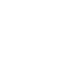

In [ ]:
q0, q1, q2, qx = cirq.LineQubit.range(4)

test_all_dj_circuits()

### Run the algorithm on a user specified function

f142 and f212 use the CCCX gate
Enter [c]onstant/[b]alanced/[u]nbalanced or function number between f0=0 and f1=255: 212

Function =  212  produces= [0 0 1 0 1 0 1 1]  Balanced

x00 = [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]  q0= 0 → 0  q1= 0 → 0  q2= 0 → 0  qx= 0 → 0  U*x= [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
x01 = [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]  q0= 0 → 0  q1= 0 → 0  q2= 0 → 0  qx= 1 → 1  U*x= [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
x02 = [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]  q0= 0 → 0  q1= 0 → 0  q2= 1 → 1  qx= 0 → 0  U*x= [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
x03 = [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]  q0= 0 → 0  q1= 0 → 0  q2= 1 → 1  qx= 1 → 1  U*x= [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
x04 = [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]  q0= 0 → 0  q1= 1 → 1  q2= 0 → 0  qx= 0 → 1  U*x= [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
x05 = [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]  q0= 0 → 0  q1= 1 → 1  q2= 0 → 0  qx= 1 → 0  U*x= [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
x06 = [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]  q0= 0 → 0  q1= 1 → 1  q2= 1 → 1  qx= 

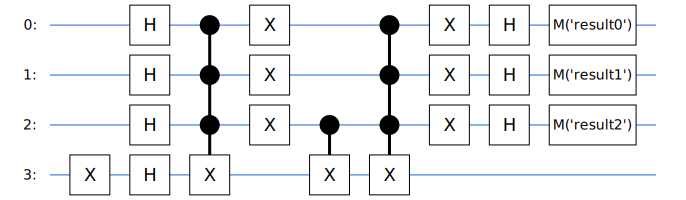


result0= 0  result1= 0  result2= 1


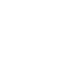

In [ ]:
q0, q1, q2, qx = cirq.LineQubit.range(4)
n = get_dj_user_function()
run_dj_circuit(n)

## Utility code to test the unitary constructions
Ensure that each function generated from quantum gates produce the outputs expected of it on each input.

In [ ]:
#@title
# This function determines if a provided set of gates corresponds to
# one of the desired special functions. It was used to find gates 
# that constructed each balanced function
def create_unitary_circuit(q0,q1,q2,qx) :
    # Get the unitary for the oracle produced by the provided gates
    oracle = [cirq.CX(q0,qx),cirq.CCX(q1,q2,qx)]
    c = cirq.Circuit()
    c.append(oracle)
    unitary = c.unitary()
    for n in range(256):
        if not constant_outputs(n) and not balanced_outputs(n):
            continue
        # Get each valid unitary from first principles
        oracle1 = make_dj_unitary(q0, q1, q2, qx, n)
        c1 = cirq.Circuit()
        c1.append(oracle1)
        unitary1 = c1.unitary()
        if numpy.array_equal(unitary, unitary1):
            print("Oracle is function ",n, function_outputs(n))
            return
    print("NOT A SPECIAL FUNCTION")
    return 

# This function ensures all functions are implemented correctly
def test_dj_gates(q0,q1,q2,qx):
    errors = 0
    x = numpy.zeros(16, dtype=int)
    for n in range(256):
        # Get the oracle produced by the circuit of gates
        oracle = get_dj_oracle2(q0, q1, q2, qx, n)
        if not constant_outputs(n) and not balanced_outputs(n):
            if oracle != []:
                print('Function ',n," invalid but has circuit")
                errors += 1
            continue
        outputs = function_outputs(n)
               
        if oracle == []:       
            print('Function ',n,' not defined ', outputs)
            errors += 1
            continue
        circuit = make_function_circuit(oracle)
        unitary = circuit.unitary()
        if unitary.shape[0] != 16 or unitary.shape[1] != 16:
            print('Function ', n , ' has unitary shape ', unitary.shape)
            errors += 1
            continue
 
        for index in range(16):
            x[index] = 1
            f = unitary.dot(x).real.astype(int)
            x[index] = 0

            # The inputs to the function
            q0i = (index >> 3) & 1
            q1i = (index >> 2) & 1
            q2i = (index >> 1) & 1
            qxi = index        & 1
            for out in range(16):
                if f[out] == 0:
                    # We are looking for the placement of the 1
                    continue
                # The output of the function
                q0o = (out >> 3) & 1
                q1o = (out >> 2) & 1
                q2o = (out >> 1) & 1
                qxo = out & 1

                if q0i != q0o:
                    print('Error: function ', n,' changes q0')
                    errors += 1
                if q1i != q1o:
                    print('Error: function ', n,' changes q1')
                    errors += 1
                if q2i != q2o:
                    print('Error: function ', n,' changes q2')
                    errors += 1
                bit = (q0i<<2)+(q1i<<1)+q2i   
                if qxi == 0:
                    if outputs[bit] != qxo:
                        print('Error: function ', n,' wrong for ', bit)
                        errors += 1
                else:
                    if outputs[bit] == qxo:
                        print('Error: function ', n,' wrong for not ', bit)
                        errors += 1
    if errors == 0:
        print("\nNo errors")
        yes_answer()
    else:
        print(errors, " ERRORS")
        no_answer()


# create_unitary_circuit(q0,q1,q2,qx)
test_dj_gates(q0,q1,q2,qx)


NameError: ignored

## Some observations

Initially it seemed quite counter-intuitive that balanced functions could have equal probability of all input lines being measured as |1> or |0>, given that the exercise was to prove that not all could be measured to be |000...0>.  For example this is the case for secret function #43.  But it is important to recognise that the input lines become entangled.  The probability that all input lines are measured to be |0>, is simply the sum of the squares of the top left two values in the first column of the unitary constructed from the Deutsch-Jozsa circuitary, the first giving the probability that qx is set |0>, and the second that qx is set |1>.  This is because all other input lines are |0>.


## Behaviour on unbalanced functions
We explore below the probability that unbalanced functions will erroneously claim to be constant functions. This has highest probability of 0.5625 = 9/16 when such functions are one output away from being constant functions, 0.25 = 1/4 probability when 2 outputs away, and lowest probability of 0.625 = 5/80 when such functions are one output away from being balanced.

Repeated execution of this algorithm, even on unbalanced functions would with high probability (but not certainty) quickly distinguish between those two special functions which returned constant values, from all others which did not.

Unbalanced function behaviour
f001  outputs  [1 0 0 0 0 0 0 0]  constant= 0.5625000000000003
f002  outputs  [0 1 0 0 0 0 0 0]  constant= 0.5625000000000003
f003  outputs  [1 1 0 0 0 0 0 0]  constant= 0.2500000000000001
f004  outputs  [0 0 1 0 0 0 0 0]  constant= 0.5625000000000003
f005  outputs  [1 0 1 0 0 0 0 0]  constant= 0.2500000000000001
f006  outputs  [0 1 1 0 0 0 0 0]  constant= 0.2500000000000001
f007  outputs  [1 1 1 0 0 0 0 0]  constant= 0.06250000000000003
f008  outputs  [0 0 0 1 0 0 0 0]  constant= 0.5625000000000003
f009  outputs  [1 0 0 1 0 0 0 0]  constant= 0.2500000000000001
f010  outputs  [0 1 0 1 0 0 0 0]  constant= 0.2500000000000001
f011  outputs  [1 1 0 1 0 0 0 0]  constant= 0.06250000000000003
f012  outputs  [0 0 1 1 0 0 0 0]  constant= 0.2500000000000001
f013  outputs  [1 0 1 1 0 0 0 0]  constant= 0.06250000000000003
f014  outputs  [0 1 1 1 0 0 0 0]  constant= 0.06250000000000003
f016  outputs  [0 0 0 0 1 0 0 0]  constant= 0.5625000000000003
f017  outputs  [1 0 0

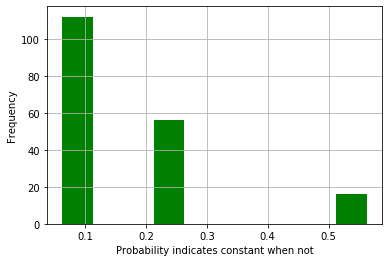

In [ ]:
#@title
def count_elements(seq) -> dict:
    hist = {}
    for value in seq:
        value = round(value, 6)
        hist[value] = hist.get(value, 0) + 1
    return hist

# Explore how unbalanced functions behave
print('Unbalanced function behaviour')
data = []
x    = numpy.zeros(16)
x[0] = 1
for n in range(256) :
    if constant_outputs(n) or balanced_outputs(n):
        continue

    outputs = function_outputs(n)
    oracle = make_dj_unitary(q0, q1, q2, qx, n)
    # Embed the oracle into a quantum circuit querying it exactly once.
    circuit = make_dj_circuit(q0, q1, q2, qx, oracle)
    unitary = circuit.unitary()
    # Extract the first column of the unitary
    col0    = unitary.dot(x).real
    prob    = sum_sq(col0, 0, 1) 
    print('f{:03d}'.format(n), ' outputs ', outputs, ' constant=', prob)
    data.append(prob)

print('\n')
elements = count_elements(data)
print(elements)

# the histogram of the data
matplotlib.pyplot.hist(data, facecolor='green')
matplotlib.pyplot.xlabel('Probability indicates constant when not')
matplotlib.pyplot.ylabel('Frequency')
matplotlib.pyplot.grid(True)
matplotlib.pyplot.show()
        

# Quantum Approximate Counting
For a function *f(x)* having many inputs we might ask how many of the outputs were 1. First use a Quantum Oracle to mark the inputs that produce an output of 1, with such inputs forming the marked set *S*. Determining the cardinality of the set *S* is then achieved by Quantum approximation counting [Aaronson]. This involves use of the Grover algorithm to be presented in Lecture 14. 

# === REFERENCES ===

Aaronson, S. and Rall, P. "Quantum Approximation Counting, Simplified"
https://arxiv.org/abs/1908.10846 2019

Cleve, R., Ekert, A. Macchiavello, C. and Mosca, M. "Quantum Algorithms Revisited" https://arxiv.org/pdf/quant-ph/9708016.pdf  1997

Deutsch, David. "Quantum theory, the Church-Turing Principle and the universal quantum computer." Proc. R. Soc. Lond. A, 400:97, 1985.

Deutsch, D. Lectures on Quantum Computing, Lecture 5 2003 http://www.quiprocone.org/Protected/DD_lectures.htm

Deutsch, D. and Jozsa, R. "Rapid Solutions of Problems by Quantum Computation", https://royalsocietypublishing.org/doi/abs/10.1098/rspa.1992.0167 1992

Hidary, J. D. "Quantum Computing: An applied Approach", Pg 97-104, 2019.

Kaye, P. Laflamme R and Mosca, M. "An Introduction to Quantum Computing", Pg 91-103, 2010

Kyrillidis, A. "Introduction to Quantum Computing: The Deutsch Algorithm" 
http://akyrillidis.github.io/notes/quant_post_8

Mermin, N. David, "Quantum Computer Science: An Introduction", Pg 41-46, 2007.

Nielsen, M. A. and Chuang, I. L, "Quantum Computation and Quantum Information", Pg 32-36, 2016

Wikipedia: https://en.wikipedia.org/wiki/Deutsch–Jozsa_algorithm 



## === SLIDES ===

Kaur, G. "Deutsch Algorithm"

Mahmoud, A. "The Deutsch-Josza Algorithm" https://cs.uwaterloo.ca/~ijdavis/qic895/Deutsch-Josza.pdf